# Building Advanced Transformers

 - Implement advanced Transformer models using Keras. 
 - Apply Transformers to real-world sequential data tasks.
 - Build, train, and evaluate Transformer models.

#### Step 1: Set up the environment.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

# Load the dataset
data = pd.read_csv('meta_prices.csv')
print(data.head())
# Extract only the 'Close' column as a 2D NumPy array (shape: n_rows x 1)
data = data[['Close']].values

# Normalize the data (range 0 ~ 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data)

# Prepare the data for training
def create_dataset(data, time_step=1): # the value 1 is just a placeholder. 
    X, Y = [], [] # X will store the input sequences, Y will store the corresponding labels
    for i in range(len(data)-time_step-1):
        # data[1:3, 0] Selects fom rows 1 to 3, in column 0. 
        a = data[i:(i+time_step), 0] # take a sliding window of length 'time_step' from column 0
        X.append(a) # add the window to input sequences 
        Y.append(data[i + time_step, 0]) # add the value right after the window as the target label
    return np.array(X), np.array(Y) # convert lists into NumPy arrays for model input

# Set the number of past timesteps to use for predicting the future value
time_step = 100 # We are using 100 previous values to predict the next one. 
# Create training sequences (X) and labels (Y) from the dataset
X, Y = create_dataset(data, time_step)

# Reshape X into 3D format [samples, timesteps, features] required by LSTMs
X = X.reshape(X.shape[0], X.shape[1], 1)

# Print out the shapes so we know the structure of our data
print('Shape of X: ', X.shape)
print('Shape of Y: ', Y.shape)

# So, for a dataset like [1,2,3,4,5] with time_step=2:
# Input windows X: [[1,2], [2,3], [3,4]]
# Labels Y: [3,4,5]


    Close
0  260.91
1  261.16
2  267.54
3  265.55
4  269.91
[[0.24585935]
 [0.24621568]
 [0.25530944]
 ...
 [0.98586049]
 [0.98878246]
 [0.99320106]]
Shape of X:  (1154, 100, 1)
Shape of Y:  (1154,)


In the code above: 


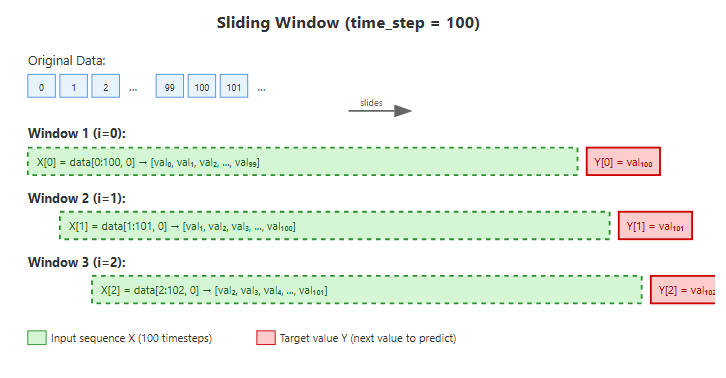

#### Step 2: Implement Multi-Head Self-Attention

Define the Multi-Head Self-Attention mechanism.

In [3]:
class MultiHeadSelfAttention(Layer):
    # Setting up the machinery for multi-head attention: Split the input into heads, Learn Q, K, V projections, and Recombine them afterward
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim # size of embedding vectors, how big each data's representation is 
        self.num_heads = num_heads # how many parallel "attention heads" to use (default 8). We will have 8 different "experts" looking at the data.
        self.projection_dim = embed_dim // num_heads # Each expert gets a smaller slice to work with (512 ÷ 8 = 64 numbers per expert)
        # Then we create 4 machines. 
        # Linear projection layer that transforms the input embeddings into "queries" (Q)
        # Each query vector represents what the current position is "looking for" in other positions
        self.query_dense = Dense(embed_dim) # Queries ask the question: “What price pattern am I looking for?”
        # Linear projection layer that transforms the input embeddings into "keys" (K)
        # Each key vector represents what information each position "contains"
        self.key_dense = Dense(embed_dim) # Keys provide the index: “What price patterns do I contain?”
        # Linear projection layer that transforms the input embeddings into "values" (V)
        # Each value vector holds the actual content that will be aggregated/weighted
        self.value_dense = Dense(embed_dim) # Values carry the actual info: “Here's the actual price information to use”
        # Final linear layer that recombines the outputs from all attention heads
        # After each head processes its own slice of information, their results are concatenated
        # This Dense layer projects that combined result back into the full embedding dimension
        self.combine_heads = Dense(embed_dim) # Merges all expert opinions back together
    
    # The attention calculator, this is where we figure out "what should pay attention to what"
    def attention(self, query, key, value):
        # 1. Compute raw attention scores by dot product: Q * K^T
        # Shape: (batch, num_heads, seq_len_q (the number of queries), seq_len_k(the number of keys))
        # Compare each query with each key (like asking "How similar is today's pattern to each past day")
        score = tf.matmul(query, key, transpose_b=True) # matmul =  matrix multiplication
        # 2. Get the dimensionality of the key vectors (dk), cast to float
        # Used for scaling to avoid overly large dot products
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        # 3. Scale the scores by sqrt(dk) to stabilize gradients (to keep numbers reasonable)
        # This is the "Scaled" part of Scaled Dot-Product Attention
        scaled_score = score / tf.math.sqrt(dim_key)
        # 4. Apply softmax along the key dimension to get attention weights
        # Each row sums to 1 -> tells the model "how much focus" to put on each token/value
        # Convert to percentages: Use softmax so all attention weights add up to 100%
        weights = tf.nn.softmax(scaled_score, axis=-1)
        # 5. Multiply weights by the values (V) to get the weighted sum (actual values) (context vector) 
        # Shape: (batch, num_heads, seq_len_q, depth_v)
        output = tf.matmul(weights, value)
        # 6. Return both the context (output) and the attention weights (for interpretability)
        return output, weights
        # If today's price action looks like what happened before a big drop 30 days ago, the model will pay more attention to that historical period.
    
    # Give each "expert" their own slice of price data to focus on
    def split_heads(self, x, batch_size):
        # First, reshape the input tensor to separate the attention heads
        # x originally has shape: (batch_size, sequence_length, total_features)
        # We're splitting total_features into (num_heads * projection_dim)
        # New shape becomes: (batch_size, sequence_length, num_heads, projection_dim)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        # Next, rearrange the dimensions so heads come before sequence
        # We swap the sequence_length and num_heads dimensions
        # Shape changes from: (batch_size, sequence_length, num_heads, projection_dim)
        # Shape changes to:   (batch_size, num_heads, sequence_length, projection_dim)
        # This makes it easier to process each attention head separately
        return tf.transpose(x, perm=[0,2,1,3])
    
    # The main process
    def call(self, inputs):
        # Get how many examples we're processing at once. 
        batch_size = tf.shape(inputs)[0]
        # Create three different "views" of the input data: 
        # Query: "What am I looking for?"
        # Key: "What information is available?"
        # Value: "What is the actual information?"
        # Transform price history into "what patterns to look for," "what patterns exist," and "actual price values"
        query = self.query_dense(inputs) # Transform input to create queries
        key = self.key_dense(inputs) # Transform input to create keys
        value = self.value_dense(inputs) # Transfrom input to create values
        # Split each of these into multiple "attention heads"
        # Think of this like having multiple people look at the same data
        # from different perspectives
        # Split into analysts: Give each of 8 specialists their piece to analyze
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        # This is where the magic happens!
        # Calculate attention - figure out which parts of the input are most important to pay attention to
        # Calculate attention: Each analyst figures out which historical prices are most relevant
        attention, _ = self.attention(query, key, value)
        # Rearrange dimensions back to prepare for combining heads
        # Swap sequence_length and num_heads back to original positions
        # Rearrange back: Put the analysis back in the right format
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Flatten the multiple attention heads back into one big tensor
        # Like merging all those different perspectives back together
        # Combine analysts: Merge all 8 specialist opinions into one prediction
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        # Apply a final transformation to the combines attention output
        output = self.combine_heads(concat_attention)
        return output

In the code above:
 - The MultiHeadSelfAttention later implements the multi-head self-attention machanism, which allows the model to focus on different parts of the input sequence simultaneously. 
 - The attention parameter computes the attention scores and weighted sum of the values. 
 - The split_heads parameter splits the input into multiple heads for parallel attention computation.
 - The call method applies the self-attention mechanism and combines the heads. 

#### Step 3: Implement Transformer block

Define the Transformer block

In [4]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) # my 8 experts
        self.ffn = tf.keras.Sequential([ # A "strategy team" that processes the analysts' findings
            Dense(ff_dim, activation="relu"), # Expand thinking
            Dense(embed_dim) # Compress back to final decision
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    # The complete analysis process
    def call(self, inputs, training):
        attn_output = self.att(inputs) # 8 eperts analyze price history
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1) # Strategy team processes everything
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In the above code: 
 - The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers. 
 - Dropout is used to prevent overfitting.
 - The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization. 



MultiHeadAttention: "What patterns do I see in the price history?"
Feed Forward Network (ffn): "Based on those patterns, what should I do?"

#### Step 4: Implement Encoder Layer

Define the Encoder layer.

In [5]:
class EncoderLayer(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon = 1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In the code above:
- The EncoderLayer is similar to the TransformerBlock but is reusable in the Transformer architecture. 
- It consists of MultiHeadSelfAttention mechanism followed by a feedforward neural network.
- Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer.
- The call method applies the self-attention, followed by the feedforward network, with residual connections and layer normalization. 

#### Step 5: Implement Transformer encoder

In [6]:
class TransformerEncoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        # How many TransformerBlcoks we're going to stack on top of each other
        # Like building a skyscraper - each floor is one TransformerBlock
        self.num_layers = num_layers 
        # Suze of our data representation (same as before)
        self.embed_dim = embed_dim
        # Create a stack of transformer blocks
        # This is like hiring multiple complete trading firms
        # If num_layers=6, we're creating 6 complete trading firms, each with full teams
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] # This creates num_layers copies of the complete TransformerBlock
        self.dropout = Dropout(rate)

    def call(self, inputs, training=False):
        # Start with the original stock price data
        x = inputs
        # Pass the data through each TransformerBlock layer, one by one
        # It's like sending your data up a skyscraper, floor by floor
        # Each floor refines and improves the analysis
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training) # Each layer takes the output from the previous layer and makes it even better
        # Return the final, super-refined analysis
        # This has been processed by ALL the TransformerBlocks
        return x 

In [7]:
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)
inputs = tf.random.uniform((1, 100, embed_dim))
outputs = transformer_encoder(inputs, training=False) # use keyword arguemnt for 'training'
print(outputs.shape)

(1, 100, 128)


#### Step 6: Build and Compile the Transformer model

Integrate the Transformer Encoder into a complete model for sequential data.

In [8]:
# Build the model
input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.Input(shape=input_shape)

# Project the inputs to the embed_dim
x = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_outputs = transformer_encoder(x)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss="mse")

# Summary of the model
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
dense_24 (Dense)             (None, 100, 128)          256       
_________________________________________________________________
transformer_encoder (Transfo (None, 100, 128)          793088    
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 12801     
Total params: 806,145
Trainable params: 806,145
Non-trainable params: 0
_________________________________________________________________


In the code above: 
 - The Transformer Encoder model defines the necesary parameters, flattens the output, and end with a dense layer to produce the final output.
 - The model is then compiled with the Adam optimizer and mean squared error loss.

#### Step 7: Train the Transformer model

Train the model on the prepared dataset.

In [14]:
model.fit(X, Y, epochs=25, batch_size=64)

Epoch 1/25
19/19 [==============================] - 1s 30ms/step - loss: 0.0978
Epoch 2/25
19/19 [==============================] - 0s 25ms/step - loss: 0.0365
Epoch 3/25
19/19 [==============================] - 1s 27ms/step - loss: 0.0289
Epoch 4/25
19/19 [==============================] - 0s 25ms/step - loss: 0.0277
Epoch 5/25
19/19 [==============================] - 0s 26ms/step - loss: 0.0310
Epoch 6/25
19/19 [==============================] - 0s 26ms/step - loss: 0.0361
Epoch 7/25
19/19 [==============================] - 0s 26ms/step - loss: 0.0191
Epoch 8/25
19/19 [==============================] - 0s 26ms/step - loss: 0.0171
Epoch 9/25
19/19 [==============================] - 0s 25ms/step - loss: 0.0179
Epoch 10/25
19/19 [==============================] - 1s 27ms/step - loss: 0.0182
Epoch 11/25
19/19 [==============================] - 0s 25ms/step - loss: 0.0197
Epoch 12/25
19/19 [==============================] - 0s 25ms/step - loss: 0.0189
Epoch 13/25
19/19 [==================

#### Step 8: Evaluate and Make Predictions

Evaluate the model's performance and make predictiosn on the dataset.

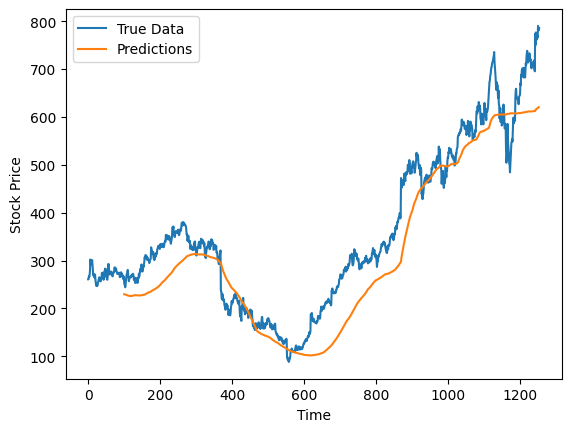

In [15]:
# make predictions 
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

data = pd.read_csv('meta_prices.csv')


# Plot the predictions
import matplotlib.pyplot as plt
plt.plot(data, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 



Let's add a dropout layer to the Transformer model and see if it makes any difference. 

In [16]:
flatten = tf.keras.layers.Flatten()(encoder_outputs)
dropout = Dropout(0.5)(flatten)
outputs = tf.keras.layers.Dense(1)(dropout)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse")

model.fit(X, Y, epochs=25, batch_size=64)

Epoch 1/25
19/19 [==============================] - 4s 26ms/step - loss: 1.6739
Epoch 2/25
19/19 [==============================] - 0s 26ms/step - loss: 1.1550
Epoch 3/25
19/19 [==============================] - 0s 25ms/step - loss: 0.7253
Epoch 4/25
19/19 [==============================] - 0s 26ms/step - loss: 0.5232
Epoch 5/25
19/19 [==============================] - 0s 26ms/step - loss: 0.4473
Epoch 6/25
19/19 [==============================] - 0s 25ms/step - loss: 0.3308
Epoch 7/25
19/19 [==============================] - 0s 26ms/step - loss: 0.2747
Epoch 8/25
19/19 [==============================] - 0s 26ms/step - loss: 0.1389
Epoch 9/25
19/19 [==============================] - 1s 26ms/step - loss: 0.0960
Epoch 10/25
19/19 [==============================] - 0s 26ms/step - loss: 0.0908
Epoch 11/25
19/19 [==============================] - 0s 26ms/step - loss: 0.0545
Epoch 12/25
19/19 [==============================] - 0s 25ms/step - loss: 0.0515
Epoch 13/25
19/19 [==================

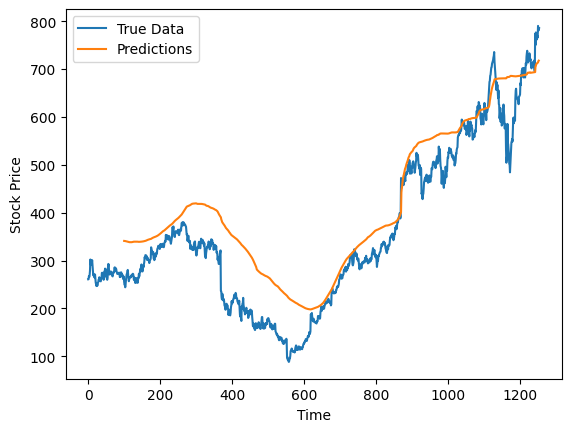

In [17]:
# make predictions 
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

data = pd.read_csv('meta_prices.csv')


# Plot the predictions
import matplotlib.pyplot as plt
plt.plot(data, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 



More movement...? 